In [225]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import torch
from tqdm import tqdm
from torch.optim import lr_scheduler

import warnings
warnings.filterwarnings("ignore")


import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [226]:
df = pd.read_csv('diabetes.csv')

In [227]:
df.shape

(768, 9)

In [228]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [229]:
df['Outcome']

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## 数据清洗

In [231]:
#使用平均值填充缺失值
df_copy = df.copy(deep=True)
df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = \
df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
df_copy.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [232]:
def full_by_mean(df,index):
    tmp = df[df[index].notnull()]
    c = tmp[[index,'Outcome']].groupby(['Outcome'])[[index]].mean().reset_index()
    df.loc[(df['Outcome']==0) & (df[index].isnull()),index ] = tmp.iloc[0,1]
    df.loc[(df['Outcome']==1) & (df[index].isnull()),index ] = tmp.iloc[0,2]
    return df

df_copy = full_by_mean(df_copy,'Glucose')
df_copy = full_by_mean(df_copy,'BloodPressure')
df_copy = full_by_mean(df_copy,'SkinThickness')
df_copy = full_by_mean(df_copy,'Insulin')
df_copy = full_by_mean(df_copy,'BMI')
df_copy.isnull().any()


Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

## 数据可视化

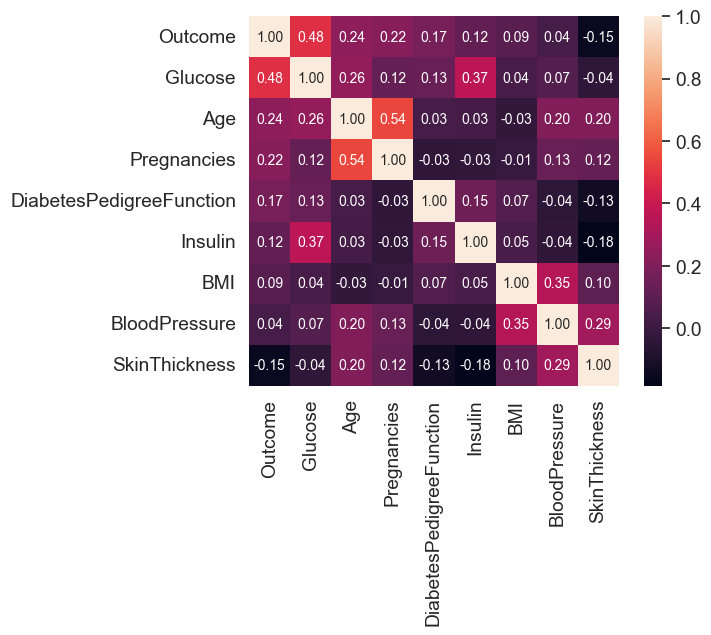

In [233]:
import seaborn as sns
#saleprice correlation matrix
k = 15 #number of variables for heatmap
corrmat = df_copy.corr()
cols = corrmat.nlargest(k, 'Outcome')['Outcome'].index
cm = np.corrcoef(df_copy[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

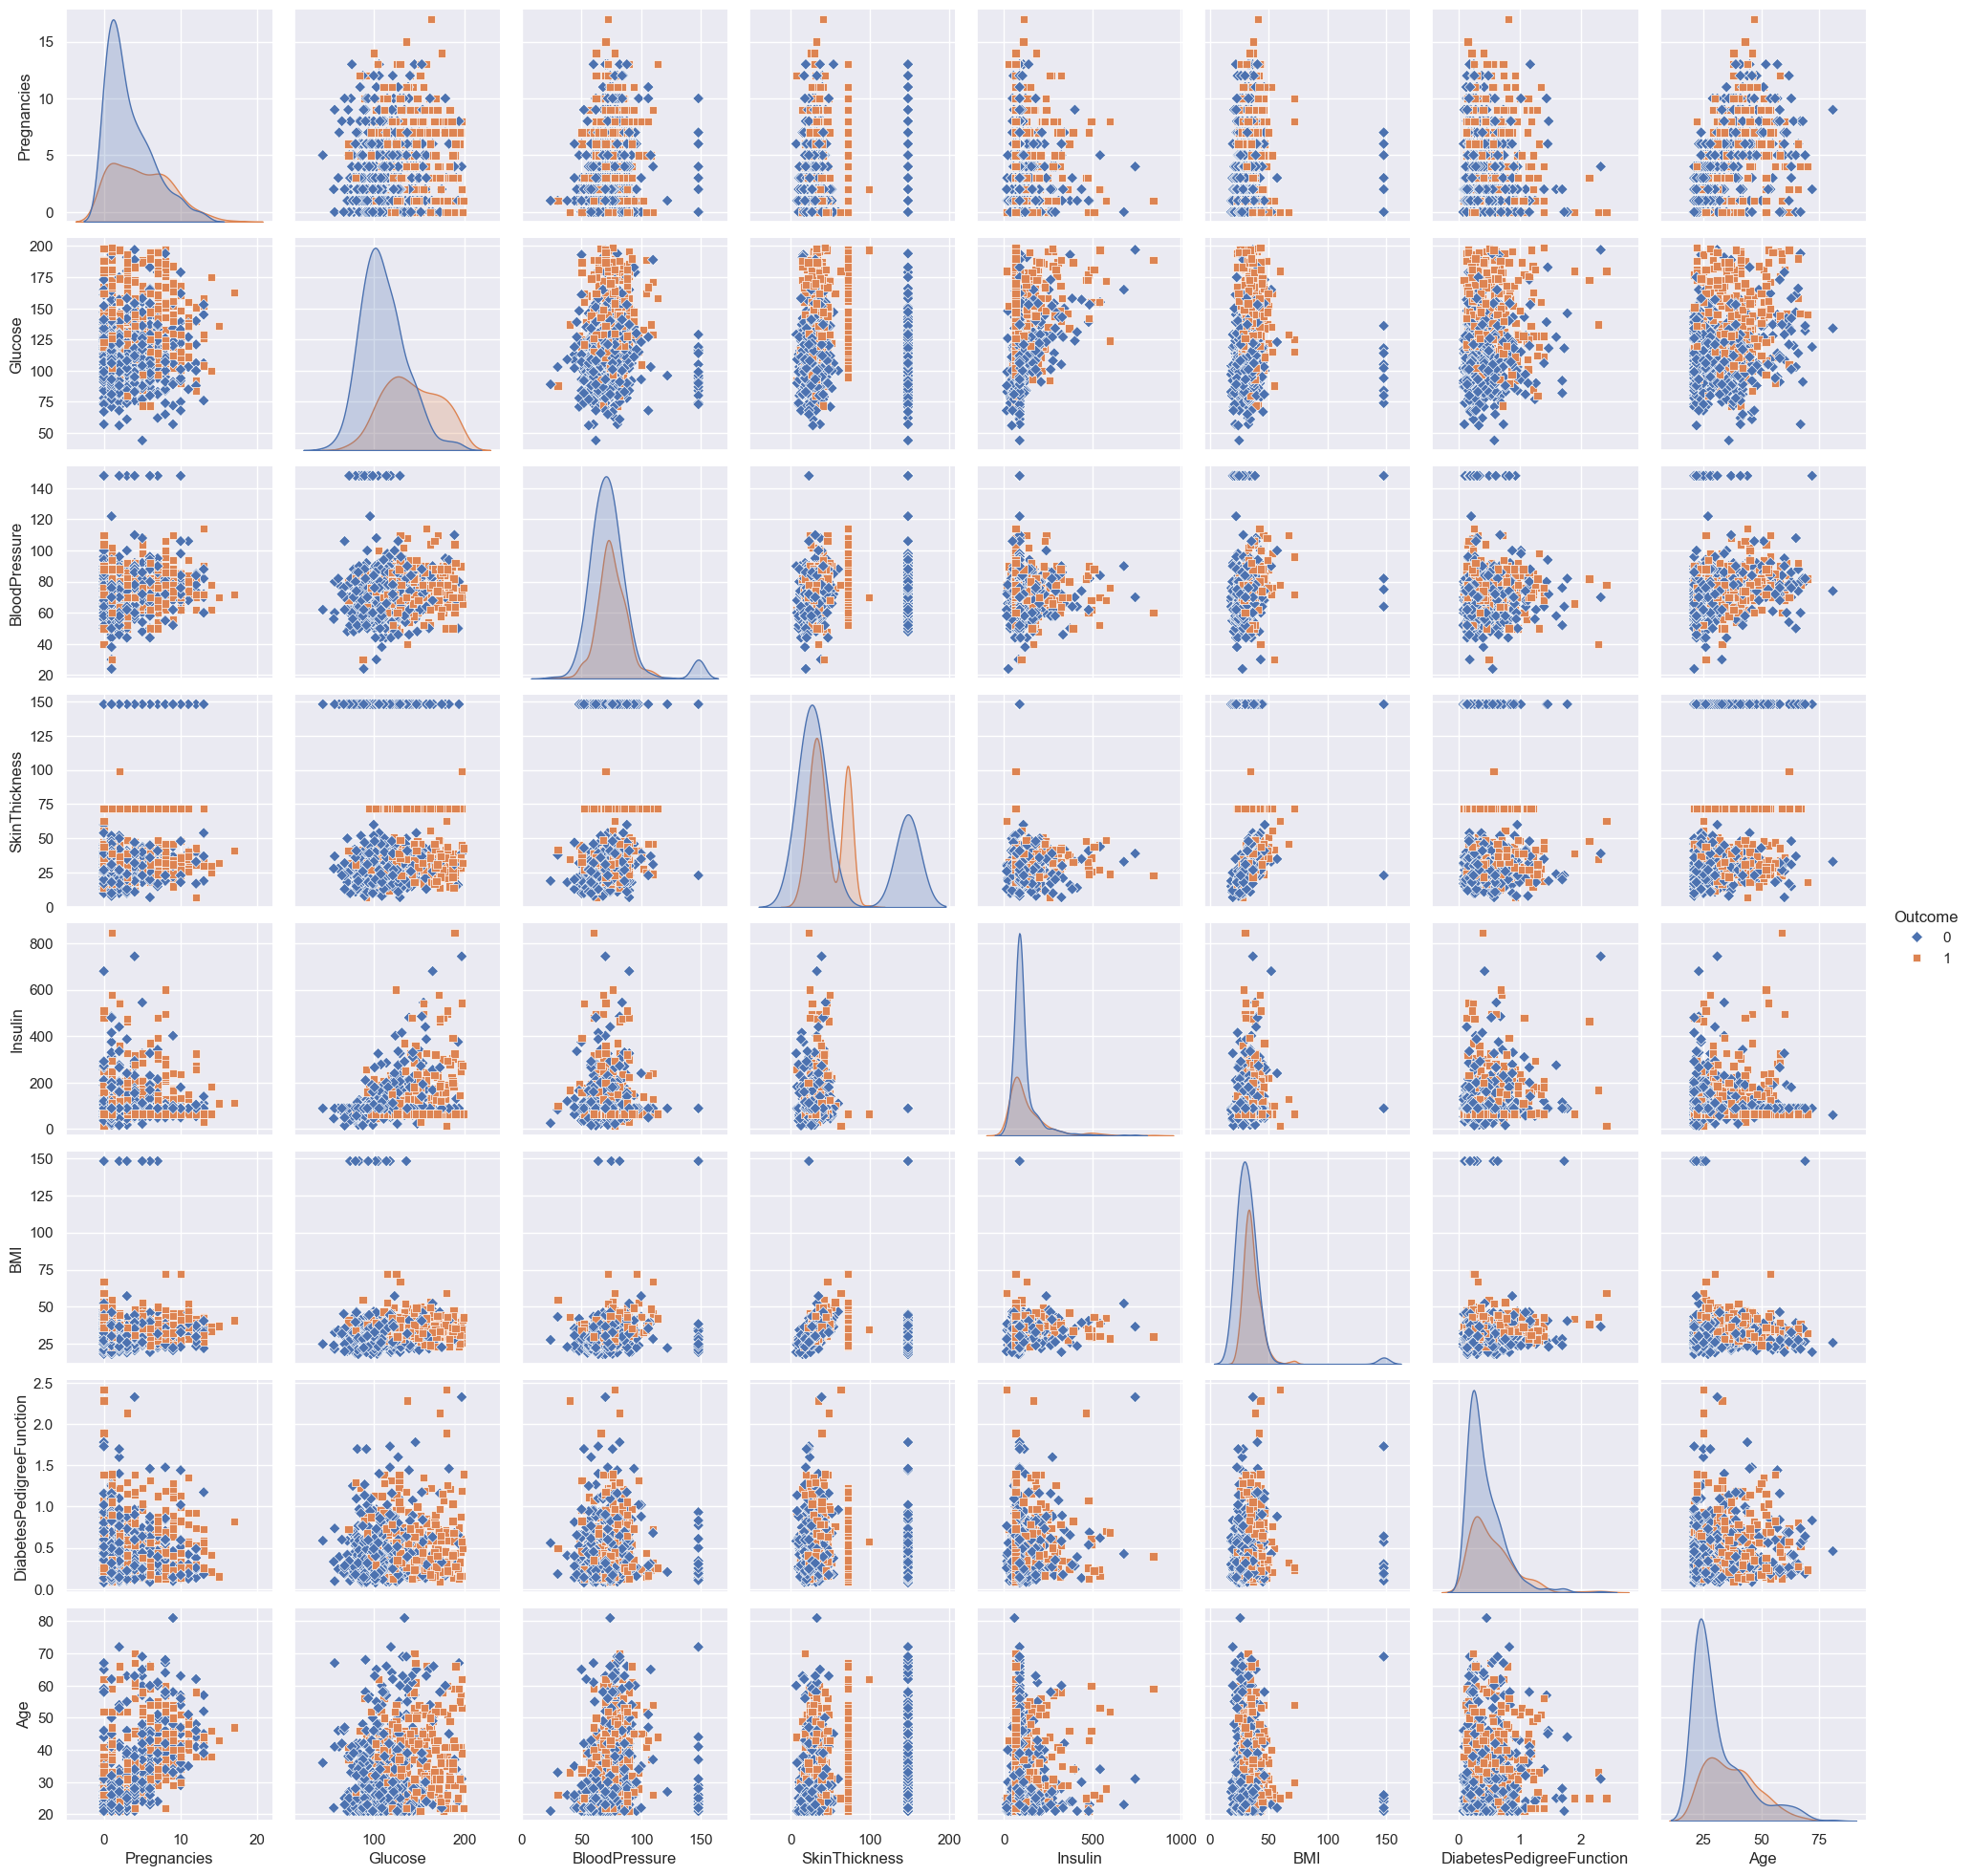

In [234]:
#scatterplot
sns.set()
cols = df_copy.columns
sns.pairplot(df_copy[cols],hue="Outcome",markers=["D", "s"])
plt.show();

## 数据标准化

In [235]:
df_copy[cols.to_list()]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,66.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,89.0,26.6,0.351,31,0
2,8,183.0,64.0,72.0,66.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,89.0,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,72.0,66.0,30.1,0.349,47,1


In [236]:
df_standard = StandardScaler().fit_transform(df_copy.drop(['Outcome'],axis=1),)

In [237]:
feature =  cols.tolist()
feature.remove('Outcome')

In [238]:
X_df_standard = pd.DataFrame(df_standard,columns=feature)
X_df_standard

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.861740,-0.134507,-0.444107,-0.568769,-0.021930,0.468492,1.425995
1,-0.844885,-1.199381,-0.490513,-0.573629,-0.321981,-0.510116,-0.365061,-0.190672
2,1.233880,2.006807,-0.609182,0.354611,-0.568769,-0.740260,0.604397,-0.105584
3,-0.844885,-1.068516,-0.490513,-0.703151,-0.268332,-0.405505,-0.920763,-1.041549
4,-1.141852,0.501861,-2.033208,-0.444107,0.525682,0.640607,5.484909,-0.020496
...,...,...,...,...,...,...,...,...
763,1.827813,-0.675922,0.102831,-0.163476,0.654441,-0.070749,-0.908682,2.532136
764,-0.547919,0.011118,-0.253176,-0.616803,-0.321981,0.201240,-0.398282,-0.531023
765,0.342981,-0.021598,-0.134507,-0.703151,-0.075193,-0.538012,-0.685193,-0.275760
766,-0.844885,0.141983,-0.846520,0.354611,-0.568769,-0.266023,-0.371101,1.170732


## 训练

In [239]:
# 要拟合的结果
label = df['Outcome']

In [240]:
# 数据分组
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df_standard, label, test_size=0.3)
X_train.shape, y_train.shape,X_test.shape, y_test.shape

((537, 8), (537,), (231, 8), (231,))

In [241]:
X_train.values

array([[-1.14185152,  0.50186146,  0.57750624, ..., -0.46129722,
        -0.72747502,  2.19178518],
       [-0.84488505, -1.65740801,  0.22149972, ..., -0.04982653,
        -0.15063235, -1.04154944],
       [-0.54791859, -1.00308393, -0.72785101, ..., -0.46129722,
         0.16043987, -0.95646168],
       ...,
       [-0.25095213, -0.28332744, -1.79587058, ..., -0.80302711,
        -1.00230582, -0.95646168],
       [-0.84488505, -0.70863809, -0.49051333, ..., -0.13351548,
        -0.08418974,  0.74529338],
       [-0.84488505, -1.13394874,  0.22149972, ...,  0.04781058,
        -1.12009045, -0.95646168]])

In [242]:
###  分类数据  转化为 tensor
train_features = torch.tensor(X_train.values, dtype=torch.float)
test_features = torch.tensor(X_test.values, dtype=torch.float)
train_labels = torch.tensor(y_train.values, dtype=torch.float).view(-1, 1)
test_labels = torch.tensor(y_test.values, dtype=torch.float).view(-1, 1)

In [243]:
batch_size = 1

# 训练集的数据加载器
train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset,                   # 数据
                                          batch_size = batch_size,    # 每个batch大小
                                          shuffle = True,             # 是否打乱数据
                                          num_workers = 0,            # 工作线程
                                          pin_memory = True)
print(f"训练集每一批{len(next(iter(train_loader))[0])}个，一共{len(train_loader)}批")

# 测试集的数据加载器
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset,                   # 数据
                                          batch_size = batch_size,    # 每个batch大小
                                          shuffle = True,             # 是否打乱数据
                                          num_workers = 0,            # 工作线程
                                          pin_memory = True)
print(f"测试集每一批{len(next(iter(train_loader))[0])}个，一共{len(test_loader)}批")


训练集每一批1个，一共537批
测试集每一批1个，一共231批


In [244]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")

In [245]:
#定义网络模型
class Net(torch.nn.Module):
    def __init__(self, in_put, hidden, hidden1, out_put):
        super().__init__()
        self.linear1 = torch.nn.Linear(in_put, hidden)
        self.linear2 = torch.nn.Linear(hidden, hidden1)
        self.linear3 = torch.nn.Linear(hidden1, out_put)
    def forward(self, data): 
        x = self.linear1(data)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x)
        return x

In [246]:
#取出输入特征个数
in_features = train_features.shape[1]
hidden, hidden1 ,out_put = 64, 32, 2

model = Net(in_features, hidden, hidden1, out_put)
model = model.to(device)

#损失函数 loss(xi,yi)=(xi−yi)2
criterion = torch.nn.MSELoss()

#梯度优化算法
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 学习率降低策略
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print("in_features:",in_features)
print("in_features:",train_features.shape)
print(model)

in_features: 8
in_features: torch.Size([537, 8])
Net(
  (linear1): Linear(in_features=8, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=2, bias=True)
)


In [247]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [248]:
# 训练集 训练函数
def train_one_batch(images, labels):
    '''
    运行一个 batch 的训练，返回当前 batch 的训练日志
    '''
    
    # 获得一个 batch 的数据和标注
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images) # 输入模型，执行前向预测
    loss = criterion(outputs, labels) # 计算当前 batch 中，每个样本的平均交叉熵损失函数值
    
    # 优化更新权重
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 获取当前 batch 的标签类别和预测类别
    _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
    preds = preds.cpu().numpy()
    loss = loss.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    log_train = {}
    log_train['epoch'] = epoch
    log_train['batch'] = batch_idx
    # 计算分类评估指标
    log_train['train_loss'] = loss
    log_train['train_accuracy'] = accuracy_score(labels, preds)
    # log_train['train_precision'] = precision_score(labels, preds, average='macro')
    # log_train['train_recall'] = recall_score(labels, preds, average='macro')
    # log_train['train_f1-score'] = f1_score(labels, preds, average='macro')
    
    return log_train

In [249]:
# 测试集 测试函数
def evaluate_testset():
    '''
    在整个测试集上评估，返回分类评估指标日志
    '''

    loss_list = []
    labels_list = []
    preds_list = []

    
    with torch.no_grad():
        for images, labels in test_loader: # 生成一个 batch 的数据和标注
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # 输入模型，执行前向预测

            # 获取整个测试集的标签类别和预测类别
            _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
            preds = preds.cpu().numpy()
            loss = criterion(outputs, labels) # 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
            loss = loss.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()

            loss_list.append(loss)
            labels_list.extend(labels)
            preds_list.extend(preds)
        
    log_test = {}
    log_test['epoch'] = epoch
    
    # 计算分类评估指标
    log_test['test_loss'] = np.mean(loss_list)
    log_test['test_accuracy'] = accuracy_score(labels_list, preds_list)
    log_test['test_precision'] = precision_score(labels_list, preds_list, average='macro')
    log_test['test_recall'] = recall_score(labels_list, preds_list, average='macro')
    log_test['test_f1-score'] = f1_score(labels_list, preds_list, average='macro')
    
    return log_test

In [250]:

epoch = 0
batch_idx = 0
best_test_accuracy = 0
# 训练日志
df_train_log = pd.DataFrame()
log_train = {}
log_train['epoch'] = 0
log_train['batch'] = 0
images, labels = next(iter(train_loader))
log_train.update(train_one_batch(images, labels))
df_train_log = df_train_log._append(log_train, ignore_index=True)

# 训练日志-测试集
df_test_log = pd.DataFrame()
log_test = {}
log_test['epoch'] = 0
log_test.update(evaluate_testset())
df_test_log = df_test_log._append(log_test, ignore_index=True)

# ## 创建wandb可视化项目
# import wandb
# wandb.init(project='fruit30', name=time.strftime('%m%d%H%M%S'))

In [251]:
%mkdir -p checkpoint

In [252]:
losses = []
accuracies = []
epochs = 50
for epoch in range(1, epochs+1):
    
    print(f'Epoch {epoch}/{epochs}')
    
    ## 训练阶段
    model.train()
    for images, labels in tqdm(train_loader): # 获得一个 batch 的数据和标注
        batch_idx += 1
        log_train = train_one_batch(images, labels)
        df_train_log = df_train_log._append(log_train, ignore_index=True)
        # wandb.log(log_train)
        
    lr_scheduler.step()

    ## 测试阶段
    model.eval()
    log_test = evaluate_testset()
    df_test_log = df_test_log._append(log_test, ignore_index=True)
    # wandb.log(log_test)
    
    # 保存最新的最佳模型文件
    if log_test['test_accuracy'] > best_test_accuracy: 
        # 删除旧的最佳模型文件(如有)
        old_best_checkpoint_path = 'checkpoint/best-{:.3f}.pth'.format(best_test_accuracy)
        if os.path.exists(old_best_checkpoint_path):
            os.remove(old_best_checkpoint_path)
        # 保存新的最佳模型文件
        best_test_accuracy = log_test['test_accuracy']
        new_best_checkpoint_path = 'checkpoint/best-{:.3f}.pth'.format(log_test['test_accuracy'])
        torch.save(model, new_best_checkpoint_path)
        print('保存新的最佳模型', 'checkpoint/best-{:.3f}.pth'.format(best_test_accuracy))
        # best_test_accuracy = log_test['test_accuracy']

df_train_log.to_csv('训练日志-训练集.csv', index=False)
df_test_log.to_csv('训练日志-测试集.csv', index=False)  

Epoch 1/50


100%|██████████| 537/537 [00:00<00:00, 945.90it/s]


保存新的最佳模型 checkpoint/best-0.541.pth
Epoch 2/50


100%|██████████| 537/537 [00:00<00:00, 1003.49it/s]


Epoch 3/50


100%|██████████| 537/537 [00:00<00:00, 1138.85it/s]


Epoch 4/50


100%|██████████| 537/537 [00:00<00:00, 1039.52it/s]


Epoch 5/50


100%|██████████| 537/537 [00:00<00:00, 1025.10it/s]


保存新的最佳模型 checkpoint/best-0.545.pth
Epoch 6/50


100%|██████████| 537/537 [00:00<00:00, 1036.42it/s]


Epoch 7/50


100%|██████████| 537/537 [00:00<00:00, 1073.67it/s]


Epoch 8/50


100%|██████████| 537/537 [00:00<00:00, 958.14it/s] 


Epoch 9/50


100%|██████████| 537/537 [00:00<00:00, 846.07it/s]


Epoch 10/50


100%|██████████| 537/537 [00:00<00:00, 988.54it/s] 


Epoch 11/50


100%|██████████| 537/537 [00:00<00:00, 963.54it/s]


Epoch 12/50


100%|██████████| 537/537 [00:00<00:00, 1069.21it/s]


Epoch 13/50


100%|██████████| 537/537 [00:00<00:00, 1055.68it/s]


Epoch 14/50


100%|██████████| 537/537 [00:00<00:00, 1065.16it/s]


Epoch 15/50


100%|██████████| 537/537 [00:00<00:00, 1066.81it/s]


Epoch 16/50


100%|██████████| 537/537 [00:00<00:00, 1032.15it/s]


Epoch 17/50


100%|██████████| 537/537 [00:00<00:00, 1067.95it/s]


Epoch 18/50


100%|██████████| 537/537 [00:00<00:00, 1036.18it/s]


Epoch 19/50


100%|██████████| 537/537 [00:00<00:00, 1051.50it/s]


Epoch 20/50


100%|██████████| 537/537 [00:00<00:00, 1061.76it/s]


Epoch 21/50


100%|██████████| 537/537 [00:00<00:00, 1020.06it/s]


Epoch 22/50


100%|██████████| 537/537 [00:00<00:00, 1014.47it/s]


Epoch 23/50


100%|██████████| 537/537 [00:00<00:00, 1003.63it/s]


Epoch 24/50


100%|██████████| 537/537 [00:00<00:00, 961.64it/s]


Epoch 25/50


100%|██████████| 537/537 [00:00<00:00, 982.64it/s]


Epoch 26/50


100%|██████████| 537/537 [00:00<00:00, 1008.63it/s]


Epoch 27/50


100%|██████████| 537/537 [00:00<00:00, 816.30it/s]


Epoch 28/50


100%|██████████| 537/537 [00:00<00:00, 868.11it/s]


Epoch 29/50


100%|██████████| 537/537 [00:00<00:00, 1009.15it/s]


Epoch 30/50


100%|██████████| 537/537 [00:00<00:00, 1019.29it/s]


Epoch 31/50


100%|██████████| 537/537 [00:00<00:00, 1018.22it/s]


Epoch 32/50


100%|██████████| 537/537 [00:00<00:00, 1007.04it/s]


Epoch 33/50


100%|██████████| 537/537 [00:00<00:00, 986.02it/s] 


Epoch 34/50


100%|██████████| 537/537 [00:00<00:00, 984.67it/s] 


Epoch 35/50


100%|██████████| 537/537 [00:00<00:00, 891.08it/s]


Epoch 36/50


100%|██████████| 537/537 [00:00<00:00, 827.98it/s]


Epoch 37/50


100%|██████████| 537/537 [00:00<00:00, 928.24it/s]


Epoch 38/50


100%|██████████| 537/537 [00:00<00:00, 838.27it/s]


Epoch 39/50


100%|██████████| 537/537 [00:00<00:00, 954.73it/s]


Epoch 40/50


100%|██████████| 537/537 [00:00<00:00, 944.71it/s]


Epoch 41/50


100%|██████████| 537/537 [00:00<00:00, 849.34it/s]


Epoch 42/50


100%|██████████| 537/537 [00:00<00:00, 775.08it/s]


Epoch 43/50


100%|██████████| 537/537 [00:00<00:00, 873.76it/s]


Epoch 44/50


100%|██████████| 537/537 [00:00<00:00, 942.70it/s]


Epoch 45/50


100%|██████████| 537/537 [00:00<00:00, 907.07it/s]


Epoch 46/50


100%|██████████| 537/537 [00:00<00:00, 920.83it/s]


Epoch 47/50


100%|██████████| 537/537 [00:00<00:00, 876.22it/s]


Epoch 48/50


100%|██████████| 537/537 [00:00<00:00, 914.12it/s]


Epoch 49/50


100%|██████████| 537/537 [00:00<00:00, 930.86it/s]


Epoch 50/50


100%|██████████| 537/537 [00:00<00:00, 915.25it/s]


In [253]:
df_train_log

,epoch,batch,train_loss,train_accuracy
0,0,0,0.03224909,1.0
1,1,1,0.030191354,1.0
2,1,2,0.8627032,0.0
3,1,3,0.74876744,0.0
4,1,4,0.015109357,1.0
...,...,...,...,...
26846,50,26846,0.024346568,1.0
26847,50,26847,0.0013875125,1.0
26848,50,26848,0.26340058,0.0
26849,50,26849,2.8792769e-05,0.0


In [254]:
df_test_log

,epoch,test_loss,test_accuracy,test_precision,test_recall,test_f1-score
0,0.0,0.263693,0.645022,0.328194,0.486928,0.392105
1,1.0,0.174932,0.541126,0.508445,0.509050,0.506728
2,2.0,0.177681,0.506494,0.465909,0.464052,0.464059
3,3.0,0.176462,0.333333,0.377729,0.383610,0.332721
4,4.0,0.165904,0.471861,0.464050,0.459904,0.452904
5,5.0,0.170473,0.545455,0.502780,0.502891,0.502329
6,6.0,0.153823,0.489177,0.466794,0.463550,0.460793
7,7.0,0.174068,0.545455,0.533690,0.537456,0.526686
8,8.0,0.159913,0.450216,0.468764,0.465561,0.444217
9,9.0,0.153143,0.497835,0.487240,0.485797,0.478027


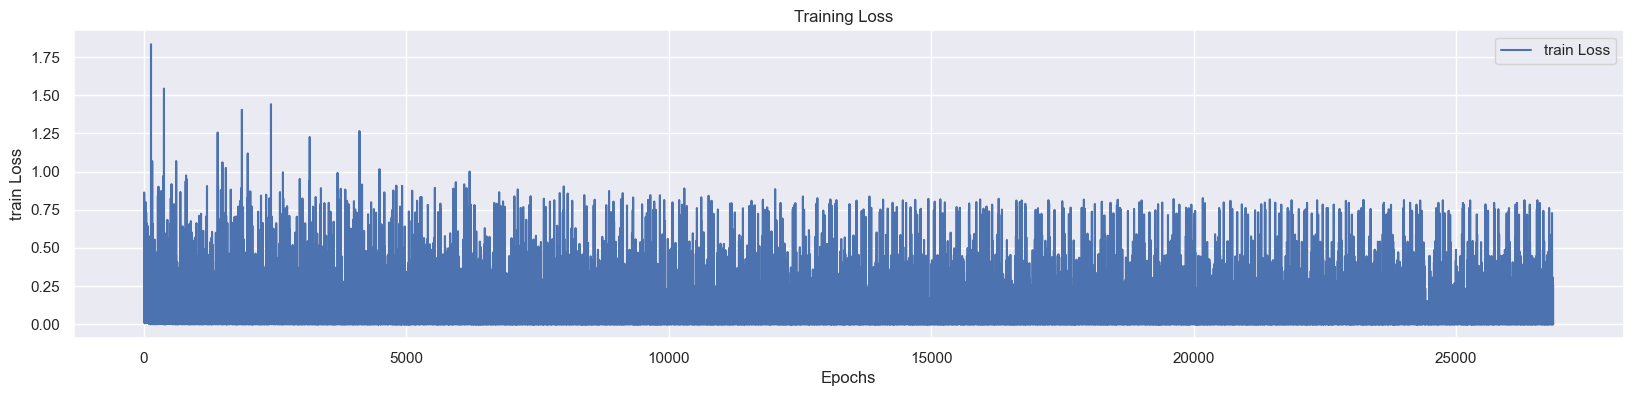

In [255]:
# 训练 绘制loss
plt.figure(figsize=(20, 4))
plt.plot(df_train_log['batch'], df_train_log['train_loss'], label='train Loss')
plt.xlabel('Epochs')
plt.ylabel('train Loss')
plt.title('Training Loss  ')
plt.legend()
plt.show()

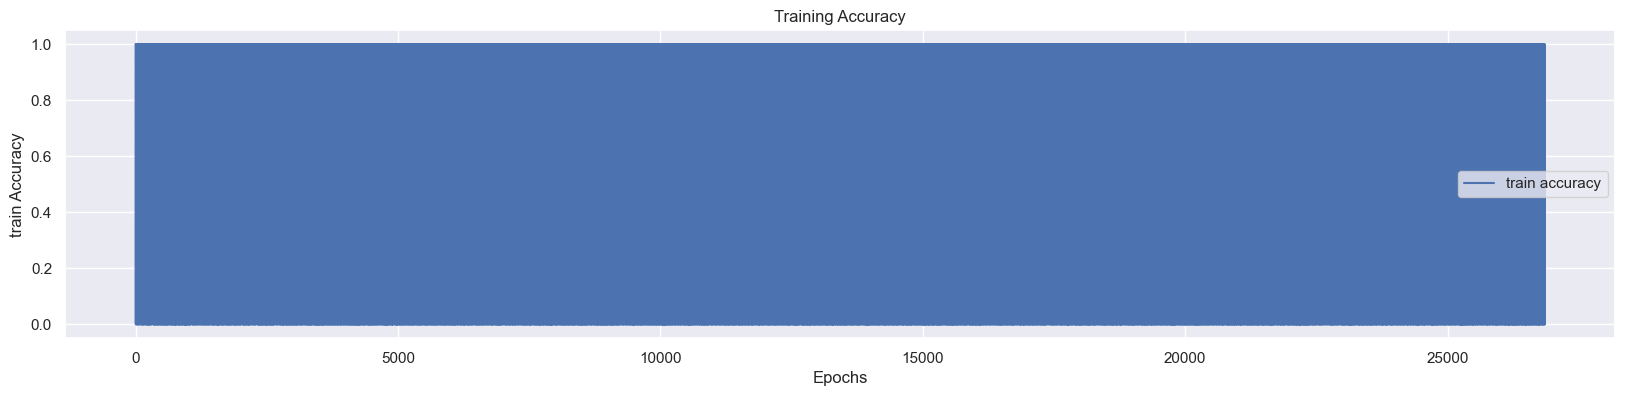

In [256]:
# 训练 绘制accuracy曲线图
plt.figure(figsize=(20, 4))
plt.plot(df_train_log['batch'], df_train_log['train_accuracy'], label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('train Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

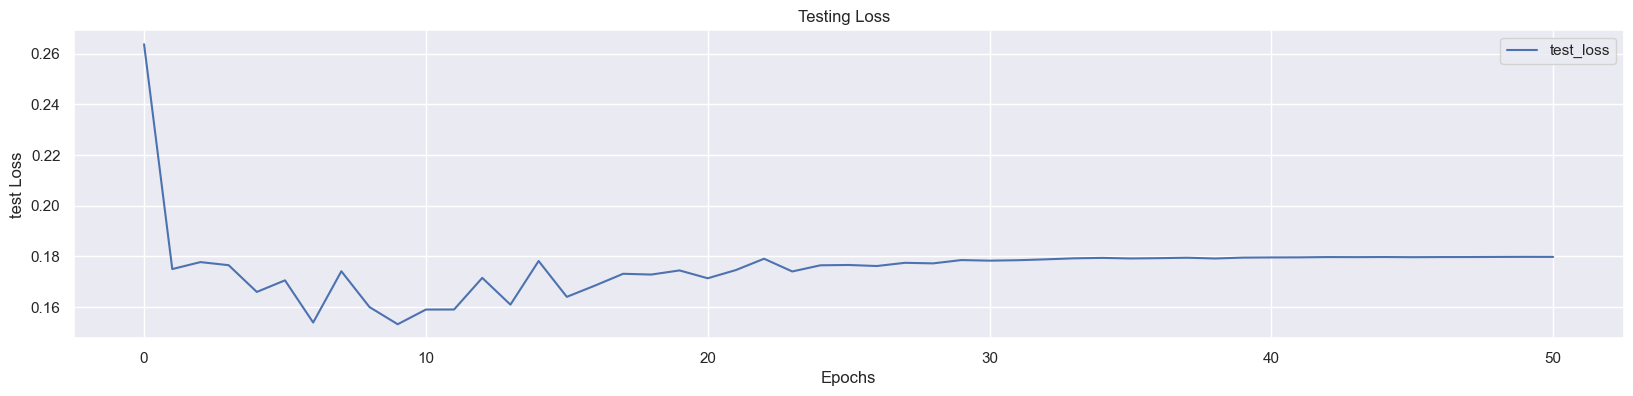

In [257]:
#  测试 绘制loss 曲线图
plt.figure(figsize=(20, 4))
plt.plot(df_test_log['epoch'], df_test_log['test_loss'], label='test_loss')
plt.xlabel('Epochs')
plt.ylabel('test Loss')
plt.title('Testing Loss  ')
plt.legend()
plt.show()

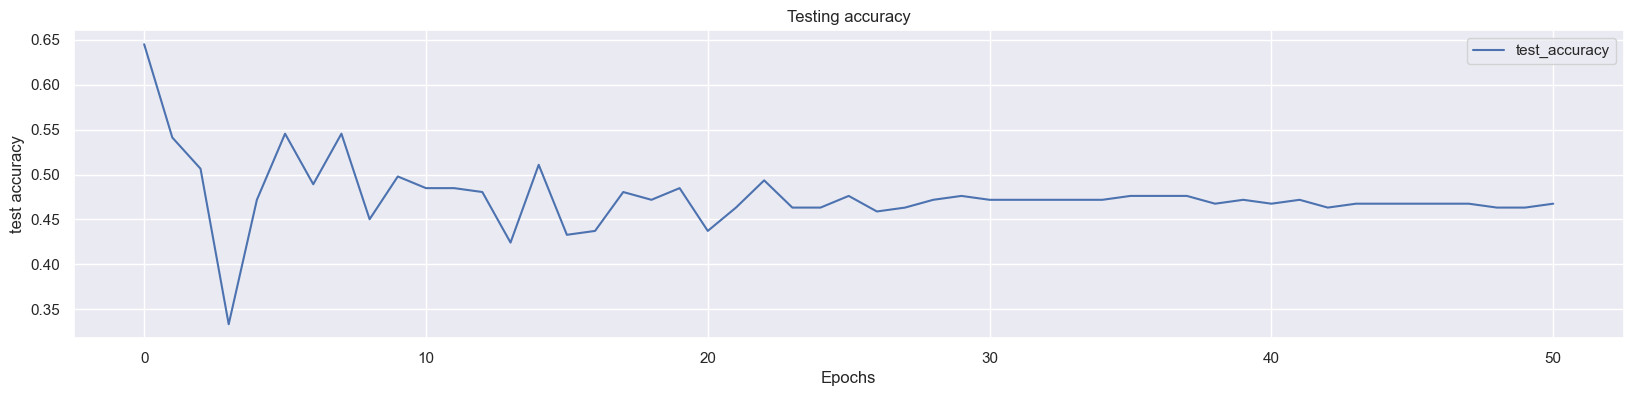

In [258]:
#  测试 绘制accuracy曲线图
plt.figure(figsize=(20, 4))
plt.plot(df_test_log['epoch'], df_test_log['test_accuracy'], label='test_accuracy')
plt.xlabel('Epochs')
plt.ylabel('test accuracy')
plt.title('Testing accuracy')
plt.legend()
plt.show()

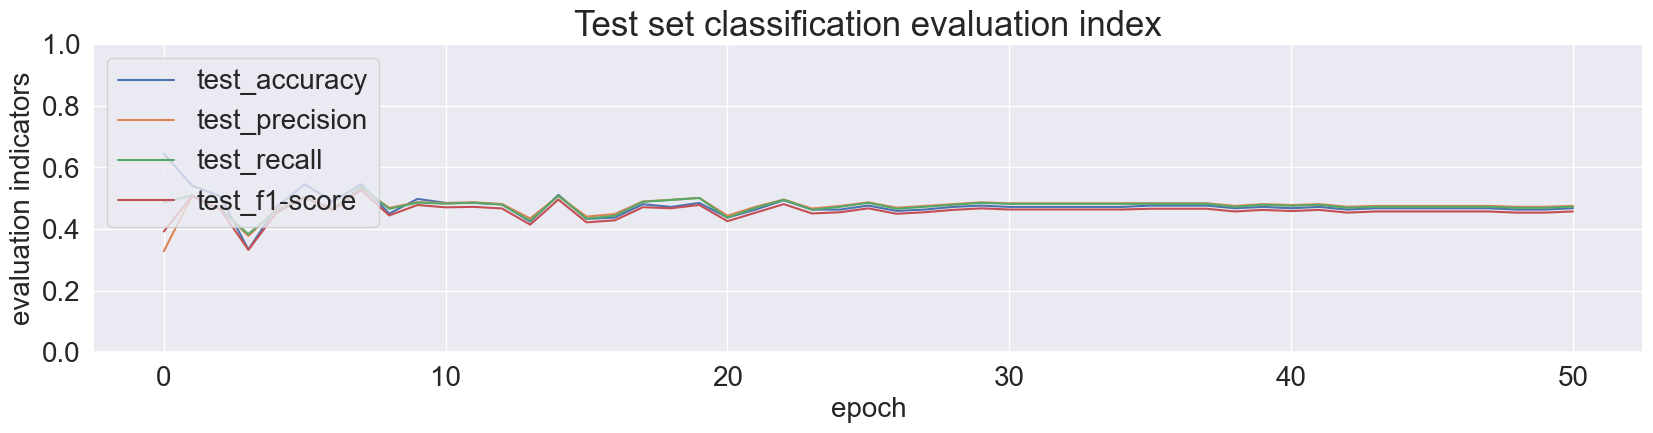

In [259]:
plt.figure(figsize=(20, 4))
metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1-score']
x = df_test_log['epoch']
for y in metrics:
    plt.plot(x, df_test_log[y], label=y)

plt.tick_params(labelsize=20)
plt.ylim([0, 1])
plt.xlabel('epoch', fontsize=20)
plt.ylabel('evaluation indicators', fontsize=20)
plt.title('Test set classification evaluation index', fontsize=25)
# plt.savefig('测试集分类评估指标.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=20)

plt.show()